### Traveltime tomography demo

This script computes 3D travel-time grids for a set of receivers in a heterogeneous velocity model. For each receiver, the algorithm solves the eikonal equation to obtain the first-arrival travel times to all grid points.


In [72]:
using WaveFront
using GLMakie
Makie.inline!(true);

Shape Model: (101, 101, 101)
Receivers: [(450, 245, 0), (450, 245, 10), (450, 245, 20), (450, 245, 30), (450, 245, 40)]
N-Receiver: 51


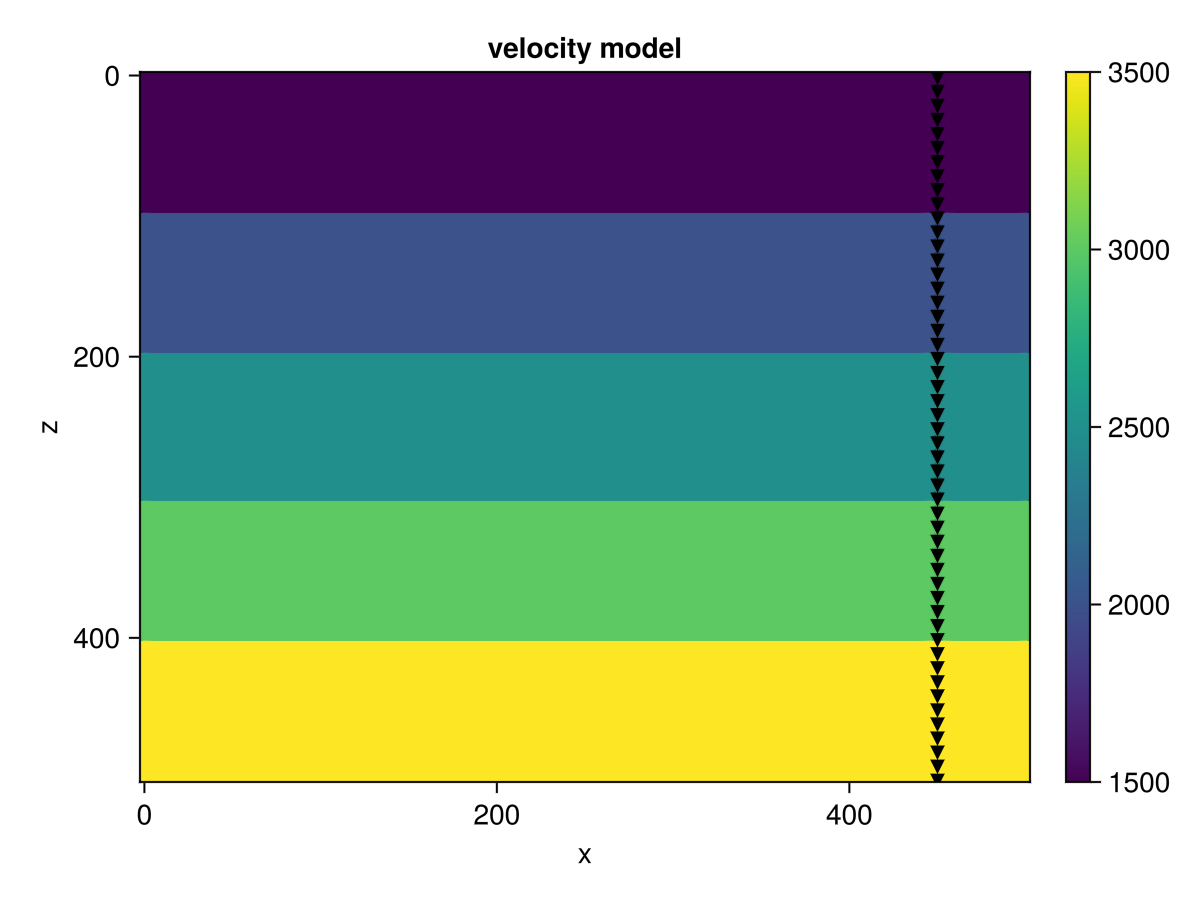

In [73]:
# create a layered velocity model
function make_3d_layered_model(x_coords, y_coords, z_coords, v_layers)

    nx, ny, nz = length(x_coords), length(y_coords), length(z_coords)
    velocity = zeros(nx, ny, nz)
    n_layers = length(v_layers)
    layer_bounds = round.(Int, LinRange(1, nz+1, n_layers+1))

    for l in 1:n_layers
        z_start = layer_bounds[l]
        z_end = layer_bounds[l+1] - 1  # bis inklusive z_end
        velocity[:, :, z_start:z_end] .= v_layers[l]
    end

    return velocity
end

h = 5
x_coords = 0:h:500
y_coords = 0:h:500
z_coords = 0:h:500
v_layers = [1500, 2000, 2500, 3000, 3500]
velocity = make_3d_layered_model(x_coords, y_coords, z_coords, v_layers);
println("Shape Model: ", size(velocity))

# define receivers 
midx = Int(floor(length(x_coords)/1.1))
midy = Int(floor(length(y_coords)/2))

n = 2
receivers = [(x_coords[midx], y_coords[midy], z) for z in z_coords[1:n:end]]
println("Receivers: ", receivers[begin:5])
println("N-Receiver: ", size(receivers,1))

# visualize
fig = Figure() 
ax = Axis(fig[1,1], xlabel="x", ylabel="z", yreversed=true, title="velocity model")
img = velocity[:,midy,:]
heatmap!(ax, x_coords, z_coords, img)
Colorbar(fig[1,2], limits=(minimum(img), maximum(img)))
rx = [r[1] for r in receivers]
rz = [r[3] for r in receivers]
scatter!(ax, rx, rz, color=:black, marker=:dtriangle, markersize=10)
fig


In [74]:
# create traveltime volumes for all receiver 
grid = Grid3D(x_coords, y_coords, z_coords, velocity);

n_rcvs = size(receivers,1);
nx = length(x_coords);
ny = length(y_coords);
nz = length(z_coords);

tt = zeros(n_rcvs, nx, ny, nz);

println("Travel time grid shape: ", size(tt))

Travel time grid shape: (51, 101, 101, 101)



Instead of computing traveltimes from each possible source location seperatly, 
one can exploit the symmetry of the two-way traveltime by reversing the problem
and treat receivers as pseudo-sources. The traveltime in both directions is identical.

For multiple receivers, computations can be parallelized.

The accuracy and computational cost depend on the chosen grid spacing and domain size.



In [75]:
# compute 
println("Number of threads: ", Threads.nthreads())
@time Threads.@threads for i in eachindex(receivers)
    rec_xyz = receivers[i]
    tt[i,:,:,:] .= fast_sweeping(grid, [rec_xyz], ϵ=0.1, verbose=false)
end

Number of threads: 8
 44.795904 seconds (8.65 G allocations: 325.220 GiB, 53.60% gc time, 0.23% compilation time)


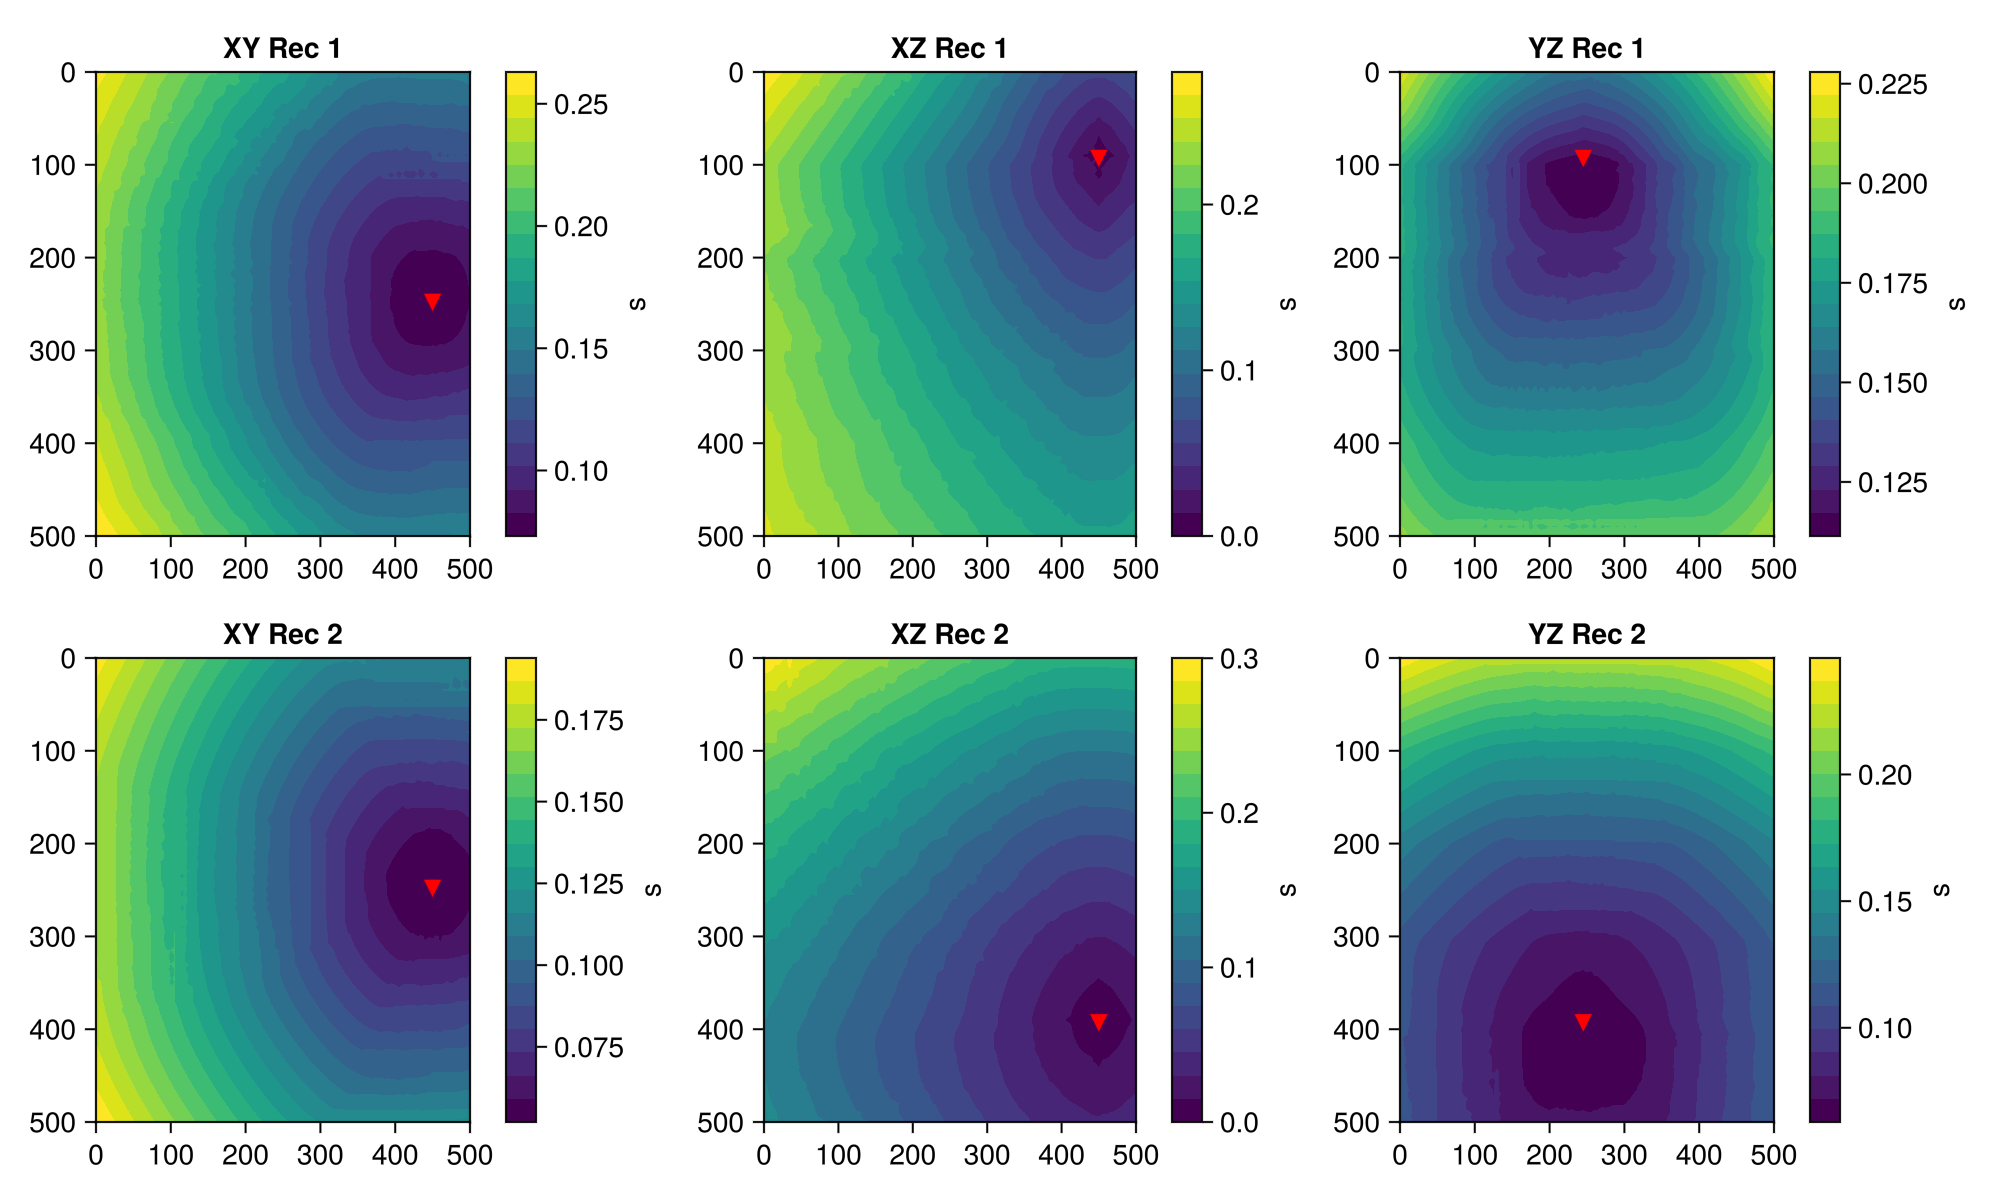

GLMakie.Screen(...)

In [76]:
# Visualize for 2 receivers 

receiver_indices = (10, 40)

fig = Figure(size=(1000,600)) 

midx = Int(floor(length(x_coords)/2))
midy = Int(floor(length(y_coords)/2))
midz = Int(floor(length(z_coords)/2))

xy = [tt[receiver_indices[1], :,:,midz], tt[receiver_indices[2], :,:,midz]]
xz = [tt[receiver_indices[1], :,midy,:], tt[receiver_indices[2], :,midy,:]]
yz = [tt[receiver_indices[1], midx,:,:], tt[receiver_indices[2], midx,:,:]]

titles = ["Rec 1", "Rec 2"]
cmap = :viridis
for i in 1:2
    rx, ry, rz = receivers[receiver_indices[i]]
    # XY
    ax_xy = Axis(fig[i,1], title="XY "*titles[i], yreversed=true)
    hm_xy = contourf!(ax_xy, x_coords, y_coords, xy[i], colormap=cmap, levels=20)
    Colorbar(fig[i,2], hm_xy, width=15, label="s")
    scatter!(ax_xy, [rx], [ry], color=:red, marker=:dtriangle, markersize=12)

    # XZ
    ax_xz = Axis(fig[i,3], title="XZ "*titles[i], yreversed=true)
    hm_xz = contourf!(ax_xz, x_coords, z_coords, xz[i], colormap=cmap, levels=20)
    Colorbar(fig[i,4], hm_xz, width=15, label="s")
    scatter!(ax_xz, [rx], [rz], color=:red, marker=:dtriangle, markersize=12)

    # YZ
    ax_yz = Axis(fig[i,5], title="YZ "*titles[i], yreversed=true)
    hm_yz = contourf!(ax_yz, y_coords, z_coords, yz[i], colormap=cmap, levels=20)
    Colorbar(fig[i,6], hm_yz, width=15, label="s")
    scatter!(ax_yz, [ry], [rz], color=:red, marker=:dtriangle, markersize=12)
end

display(fig)

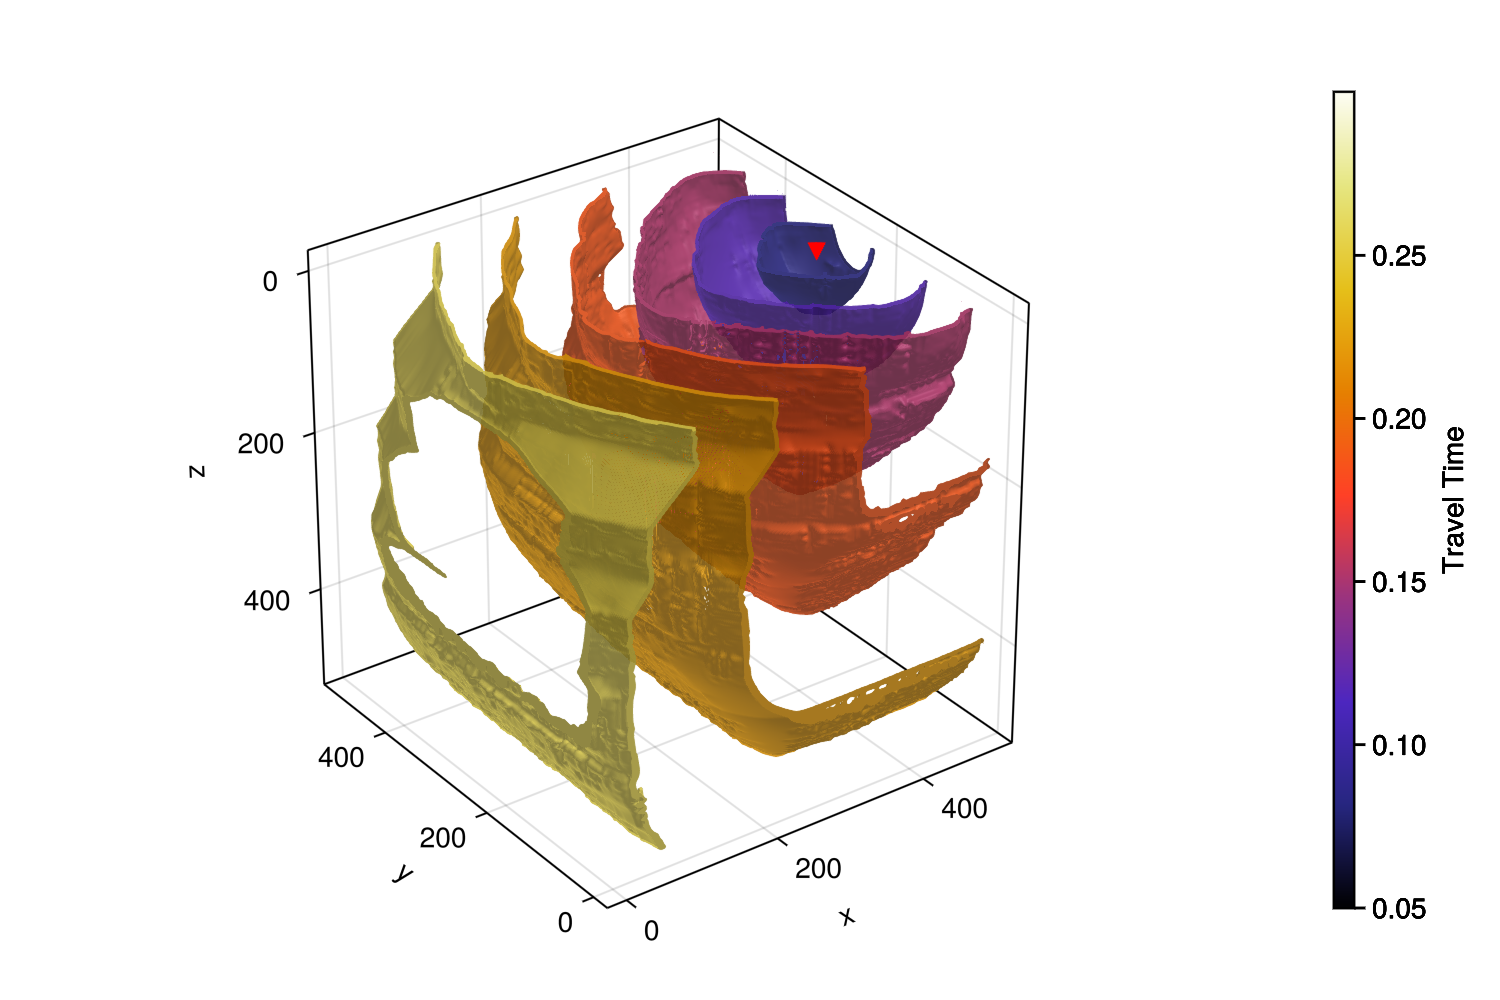

In [77]:
# isosurface plot for one receiver

receiver_index = 1

tt_rev = reverse(tt[receiver_index,:,:,:], dims=3) # flip z axis for plot 

fig = Figure(size=(750,500))
ax = Axis3(fig[1, 1],aspect=(1, 1, 1),
                elevation=π/6,
                azimuth = 1.3 * pi,
                perspectiveness=0.1, zreversed=true)

cmap = :CMRmap
isovals = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for (i,isoval) in enumerate(isovals)
                
volume!(ax, x_coords[begin]..x_coords[end],
            y_coords[begin]..y_coords[end],
            z_coords[end]..z_coords[begin],
            tt_rev,
        algorithm=:iso, isorange=0.001, isovalue=isoval,
        colormap=cmap, alpha=0.9)

rx, ry, rz = receivers[receiver_index]
scatter!(ax, [rx], [ry], [rz],  color=:red, marker=:dtriangle, markersize=12)
Colorbar(fig[1,2],
    colormap = cmap,
    limits = (minimum(isovals), maximum(isovals)),
    label = "Travel Time",
    width=10
)

end

fig